In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

from models import *
from autoencoder import *
from utils import *
from data import *

In [2]:
import os, pickle
import time
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
latent_dim = 16
ts_configs = [
    ("Temperatures", Temperatures, 31),
    ("Births",       Births,       31),
    ("Saugeen",      Saugeen,      365),
]

autoencoder_embedding_flags = [False, True]
metrics_list = ["euclidean", "manhattan", "cosine"]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda



Training AE on Temperatures (window_size=31)
  Epoch 1/50 — loss: 0.516587
  Epoch 2/50 — loss: 0.316547
  Epoch 3/50 — loss: 0.289347
  Epoch 4/50 — loss: 0.267017
  Epoch 5/50 — loss: 0.279587
  Epoch 6/50 — loss: 0.242615
  Epoch 7/50 — loss: 0.239416
  Epoch 8/50 — loss: 0.262087
  Epoch 9/50 — loss: 0.236477
  Epoch 10/50 — loss: 0.227150
  Epoch 11/50 — loss: 0.244753
  Epoch 12/50 — loss: 0.218955
  Epoch 13/50 — loss: 0.218292
  Epoch 14/50 — loss: 0.215855
  Epoch 15/50 — loss: 0.213315
  Epoch 16/50 — loss: 0.253850
  Epoch 17/50 — loss: 0.205061
  Epoch 18/50 — loss: 0.199656
  Epoch 19/50 — loss: 0.208042
  Epoch 20/50 — loss: 0.190004
  Epoch 21/50 — loss: 0.200540
  Epoch 22/50 — loss: 0.198779
  Epoch 23/50 — loss: 0.199073
  Epoch 24/50 — loss: 0.191987
  Epoch 25/50 — loss: 0.196690
  Epoch 26/50 — loss: 0.188953
  Epoch 27/50 — loss: 0.206482
  Epoch 28/50 — loss: 0.202312
  Epoch 29/50 — loss: 0.200293
  Epoch 30/50 — loss: 0.192206
  Epoch 31/50 — loss: 0.179856
  

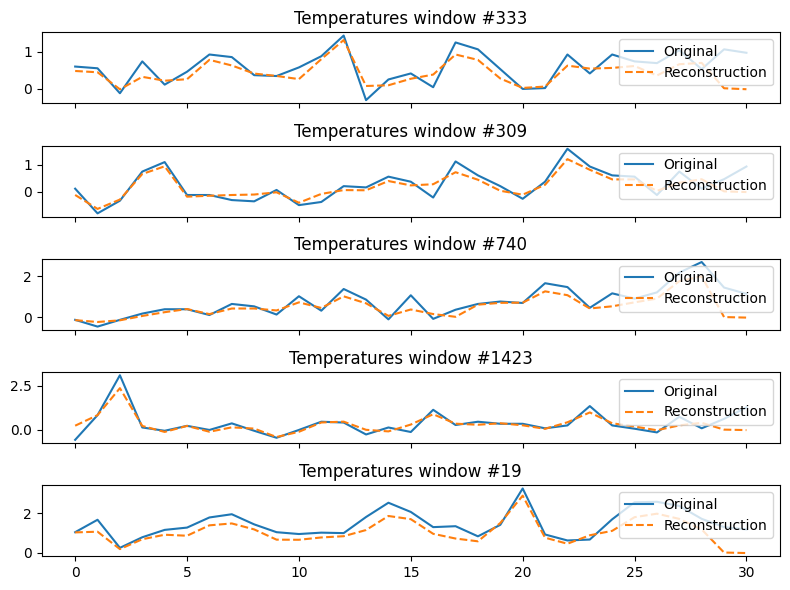

Reconstruction MSE → train: 0.148404, val: 0.123095, test: 0.142717


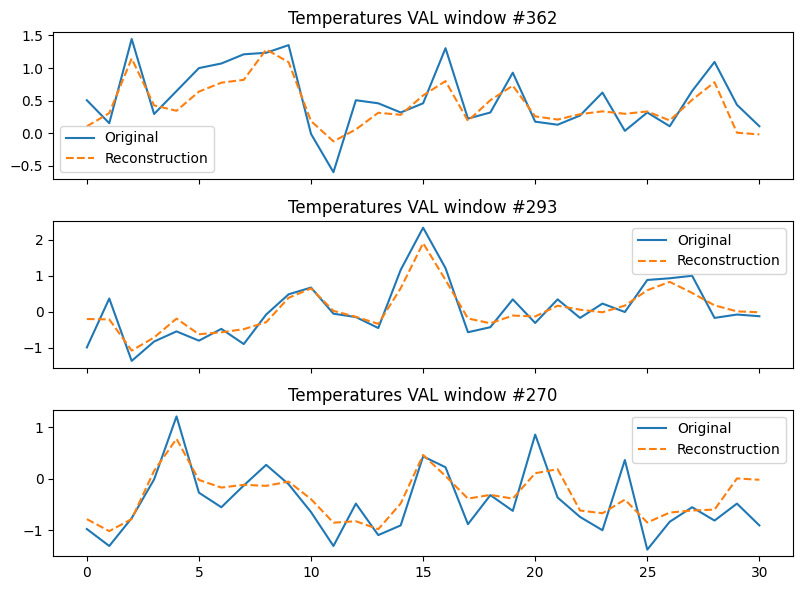


Training AE on Births (window_size=31)
  Epoch 1/50 — loss: 0.451208
  Epoch 2/50 — loss: 0.247418
  Epoch 3/50 — loss: 0.216455
  Epoch 4/50 — loss: 0.206094
  Epoch 5/50 — loss: 0.192806
  Epoch 6/50 — loss: 0.189036
  Epoch 7/50 — loss: 0.181268
  Epoch 8/50 — loss: 0.173487
  Epoch 9/50 — loss: 0.167983
  Epoch 10/50 — loss: 0.166360
  Epoch 11/50 — loss: 0.166575
  Epoch 12/50 — loss: 0.163221
  Epoch 13/50 — loss: 0.169121
  Epoch 14/50 — loss: 0.158266
  Epoch 15/50 — loss: 0.156136
  Epoch 16/50 — loss: 0.154781
  Epoch 17/50 — loss: 0.153472
  Epoch 18/50 — loss: 0.153797
  Epoch 19/50 — loss: 0.155416
  Epoch 20/50 — loss: 0.152269
  Epoch 21/50 — loss: 0.147778
  Epoch 22/50 — loss: 0.149651
  Epoch 23/50 — loss: 0.150365
  Epoch 24/50 — loss: 0.148074
  Epoch 25/50 — loss: 0.148139
  Epoch 26/50 — loss: 0.144472
  Epoch 27/50 — loss: 0.146951
  Epoch 28/50 — loss: 0.142499
  Epoch 29/50 — loss: 0.144323
  Epoch 30/50 — loss: 0.141759
  Epoch 31/50 — loss: 0.143026
  Epoch 

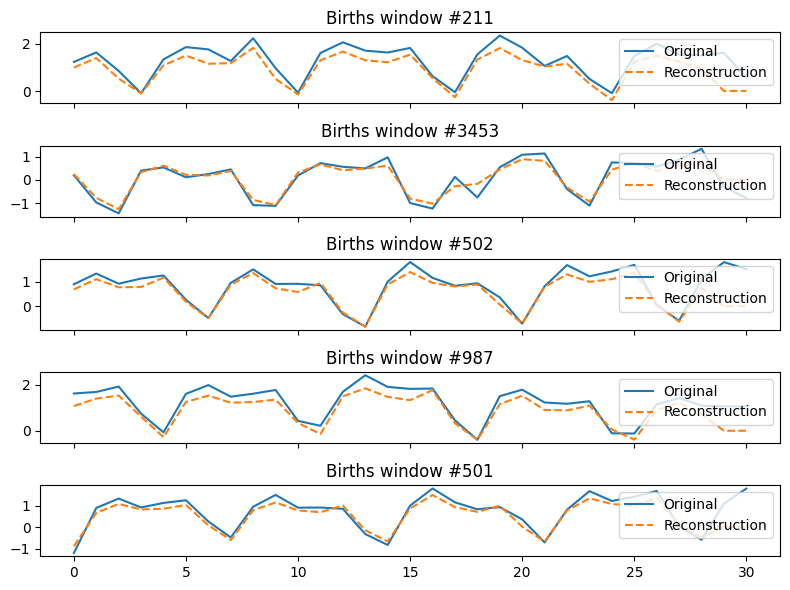

Reconstruction MSE → train: 0.119155, val: 0.178211, test: 0.369601


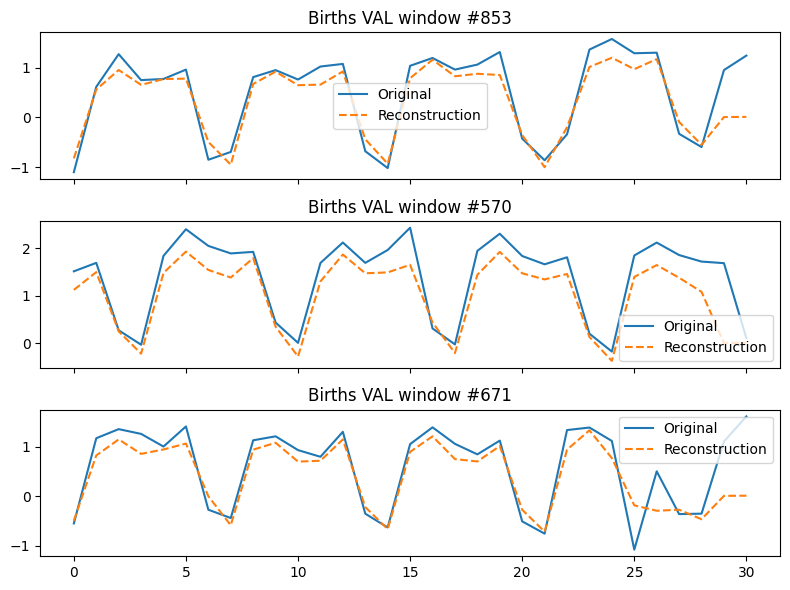


Training AE on Saugeen (window_size=365)
  Epoch 1/50 — loss: 0.115671
  Epoch 2/50 — loss: 0.044105
  Epoch 3/50 — loss: 0.036063
  Epoch 4/50 — loss: 0.032405
  Epoch 5/50 — loss: 0.029749
  Epoch 6/50 — loss: 0.027749
  Epoch 7/50 — loss: 0.027544
  Epoch 8/50 — loss: 0.025843
  Epoch 9/50 — loss: 0.025004
  Epoch 10/50 — loss: 0.023464
  Epoch 11/50 — loss: 0.023310
  Epoch 12/50 — loss: 0.023140
  Epoch 13/50 — loss: 0.022346
  Epoch 14/50 — loss: 0.022310
  Epoch 15/50 — loss: 0.022240
  Epoch 16/50 — loss: 0.021199
  Epoch 17/50 — loss: 0.020747
  Epoch 18/50 — loss: 0.020895
  Epoch 19/50 — loss: 0.020256
  Epoch 20/50 — loss: 0.020178
  Epoch 21/50 — loss: 0.019841
  Epoch 22/50 — loss: 0.020081
  Epoch 23/50 — loss: 0.020307
  Epoch 24/50 — loss: 0.019102
  Epoch 25/50 — loss: 0.018955
  Epoch 26/50 — loss: 0.019085
  Epoch 27/50 — loss: 0.018906
  Epoch 28/50 — loss: 0.019093
  Epoch 29/50 — loss: 0.019286
  Epoch 30/50 — loss: 0.018214
  Epoch 31/50 — loss: 0.017957
  Epoc

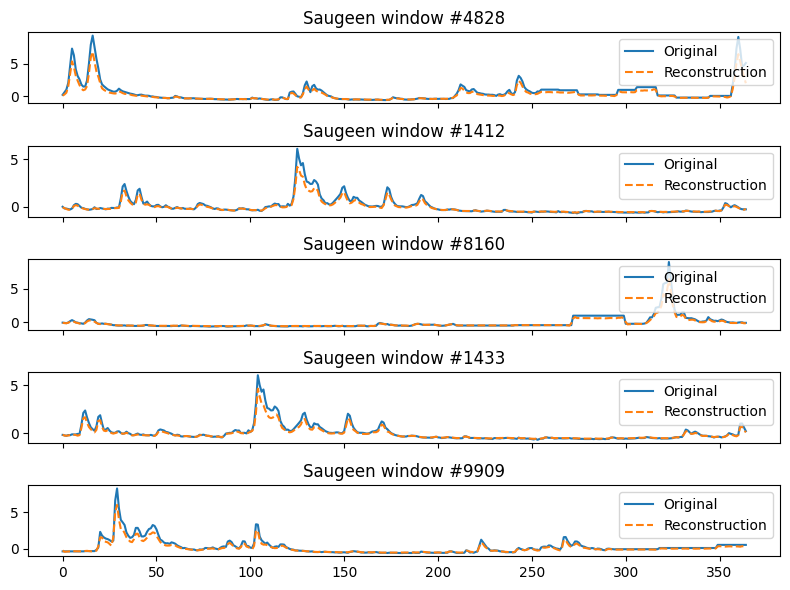

Reconstruction MSE → train: 0.071377, val: 0.085996, test: 0.084017


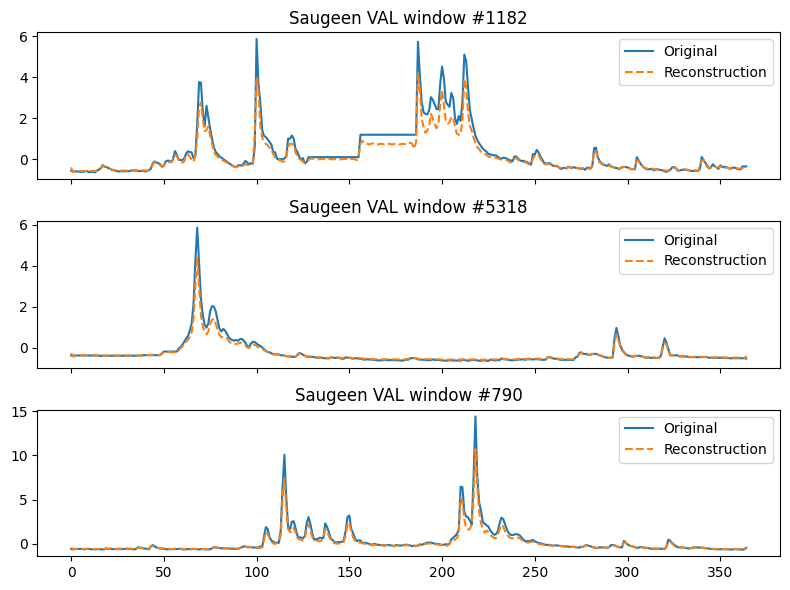

In [4]:
epochs    = 50
lr        = 1e-3
dropout_p = 0.1

for ds_name, DS, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=64, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_train)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

     # 1) Prepare your splits again
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # 2) Compute reconstruction MSE on each split
    def recon_mse(ae, X):
        ae.eval()
        with torch.no_grad():
            # batch through DataLoader if needed; here we do it all at once for simplicity
            X_t = torch.tensor(X, dtype=torch.float).unsqueeze(1).to(device)
            R_t = ae(X_t).cpu().squeeze(1).numpy()
        return ((X - R_t)**2).mean()

    mse_tr  = recon_mse(ae, X_train)
    mse_val = recon_mse(ae, X_val)
    mse_te  = recon_mse(ae, X_test)
    print(f"Reconstruction MSE → train: {mse_tr:.6f}, val: {mse_val:.6f}, test: {mse_te:.6f}")

    # 3) Plot 3 random validation windows vs. reconstructions
    import random
    sample_idxs = random.sample(range(len(X_val)), 3)
    fig, axs = plt.subplots(3,1,figsize=(8,6),sharex=True)
    for ax, idx in zip(axs, sample_idxs):
        orig = X_val[idx]
        with torch.no_grad():
            inp   = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, "--", label="Reconstruction")
        ax.set_title(f"{ds_name} VAL window #{idx}")
        ax.legend()
    plt.tight_layout()
    plt.show()

In [5]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE: {save_path}")


→ Dataset: Temperatures (window_size=31)
    → Training ARIMA… DONE: models\Temperatures_ARIMA.pkl
    → Training ExpSmoothing… DONE: models\Temperatures_ExpSmoothing.pkl
    → Training LinearRegression… DONE: models\Temperatures_LinearRegression.pkl
    → Training RandomForest… DONE: models\Temperatures_RandomForest.pkl
    → Training SVR… DONE: models\Temperatures_SVR.pkl
    → Training GradientBoosting… DONE: models\Temperatures_GradientBoosting.pkl
    → Training DT… DONE: models\Temperatures_DT.pkl
    → Training MLP… DONE: models\Temperatures_MLP.pkl
    → Training LSTM… 1/30 0.56976 | 15/30 0.34629 | 30/30 0.33509 | DONE: models\Temperatures_LSTM.pkl
    → Training BiLSTM… 1/30 0.51856 | 15/30 0.35658 | 30/30 0.33064 | DONE: models\Temperatures_BiLSTM.pkl
    → Training CNNLSTM… 1/30 0.42931 | 15/30 0.33030 | 30/30 0.27593 | DONE: models\Temperatures_CNNLSTM.pkl

→ Dataset: Births (window_size=31)
    → Training ARIMA… DONE: models\Births_ARIMA.pkl
    → Training ExpSmoothing… 

In [6]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

loaded = {}
for ds_name, DS, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # 1) Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {ae_ckpt}")
    
    # 2) Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP",
        "LSTM",
        "BiLSTM",
        "CNNLSTM",
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
        print(f"     {name} loaded from {pkl_path}")
    
    # store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Temperatures (window_size=31)
     AE loaded from autoencoders\ae_Temperatures.pth
     ARIMA loaded from models\Temperatures_ARIMA.pkl
     ExpSmoothing loaded from models\Temperatures_ExpSmoothing.pkl
     LinearRegression loaded from models\Temperatures_LinearRegression.pkl
     RandomForest loaded from models\Temperatures_RandomForest.pkl
     SVR loaded from models\Temperatures_SVR.pkl
     GradientBoosting loaded from models\Temperatures_GradientBoosting.pkl
     DT loaded from models\Temperatures_DT.pkl
     MLP loaded from models\Temperatures_MLP.pkl
     LSTM loaded from models\Temperatures_LSTM.pkl
     BiLSTM loaded from models\Temperatures_BiLSTM.pkl
     CNNLSTM loaded from models\Temperatures_CNNLSTM.pkl

→ Loading models for Births (window_size=31)
     AE loaded from autoencoders\ae_Births.pth
     ARIMA loaded from models\Births_ARIMA.pkl
     ExpSmoothing loaded from models\Births_ExpSmoothing.pkl
     LinearRegression loaded from models\Births_L

In [7]:
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")



=== Validation RoC for Temperatures (window_size=31) ===
RoC sizes
  ARIMA                77 entries
  ExpSmoothing         56 entries
  LinearRegression     50 entries
  RandomForest        105 entries
  SVR                  84 entries
  GradientBoosting     41 entries
  DT                  145 entries
  MLP                 111 entries
  LSTM                 58 entries
  BiLSTM               59 entries
  CNNLSTM              95 entries

=== Validation RoC for Births (window_size=31) ===
RoC sizes
  ARIMA               108 entries
  ExpSmoothing         57 entries
  LinearRegression    208 entries
  RandomForest        192 entries
  SVR                 179 entries
  GradientBoosting    217 entries
  DT                  186 entries
  MLP                 218 entries
  LSTM                166 entries
  BiLSTM              105 entries
  CNNLSTM             159 entries

=== Validation RoC for Saugeen (window_size=365) ===
RoC sizes
  ARIMA               504 entries
  ExpSmoothing       102

In [8]:
# Lists to collect detailed disagreements and high-level summaries
disagreements = []
summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")
    # rebuild all splits
    ts = DS(path=None)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    y_true = y_test if isinstance(y_test, np.ndarray) else y_test.cpu().numpy()

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w  # raw query
            # nearest‐RoC lookup in raw space
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_true, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()  # latent query (torch.Tensor)
            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    # entry is already a tensor
                    d = compute_distance(q, entry, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_true, lat_preds)

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_true, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print concise line ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})"
        )

df_dis  = pd.DataFrame(disagreements)
df_sum  = pd.DataFrame(summary_list)

# save for later
df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/summary.csv",     index=False)

Bottleneck size: 8

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.3851@2.78s | lat MSE=0.4081@6.08s | dis=611/882 (69.27%)
[manhattan] raw MSE=0.3811@3.54s | lat MSE=0.3954@6.87s | dis=586/882 (66.44%)
[ cosine  ] raw MSE=0.4120@4.76s | lat MSE=0.3975@13.67s | dis=578/882 (65.53%)

=== Dataset: Births ===
[euclidean] raw MSE=0.4023@9.40s | lat MSE=0.4225@23.94s | dis=658/1796 (36.64%)
[manhattan] raw MSE=0.4089@12.52s | lat MSE=0.4178@25.19s | dis=675/1796 (37.58%)
[ cosine  ] raw MSE=0.3421@16.02s | lat MSE=0.3558@50.01s | dis=849/1796 (47.27%)

=== Dataset: Saugeen ===
[euclidean] raw MSE=0.1563@86.58s | lat MSE=0.1641@195.66s | dis=1659/5571 (29.78%)
[manhattan] raw MSE=0.1571@110.56s | lat MSE=0.1272@257.40s | dis=2459/5571 (44.14%)
[ cosine  ] raw MSE=0.1508@158.11s | lat MSE=0.1429@484.55s | dis=2298/5571 (41.25%)


In [9]:
df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# 3) Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# 4) Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# 5) Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# 6) Display concise table
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,Temperatures,euclidean,0.512275,0.487725,0.307256
1,Temperatures,manhattan,0.525597,0.474403,0.335601
2,Temperatures,cosine,0.480969,0.519031,0.344671
3,Births,euclidean,0.519757,0.480243,0.633630
4,Births,manhattan,0.493333,0.506667,0.624165
5,Births,cosine,0.511190,0.488810,0.527283
6,Saugeen,euclidean,0.493671,0.506329,0.702208
7,Saugeen,manhattan,0.496950,0.503050,0.558607
8,Saugeen,cosine,0.493037,0.506963,0.587507
